## Matrix factorization

We want to minimize
$$\min_X f(X)=f(U,V):=\frac 1 2 \|U V^\top - A\|^2_F,$$
where  $A\in {\mathbb R}^{m\times n}$, $U\in {\mathbb R}^{m\times r}$, $V\in {\mathbb R}^{n\times r}$ and $r<\min\{m,n\}$.
The gradient is given by $\nabla f(X) = [(UV^\top -A) V, (UV^\top-A)^\top U].$

This is a nonconvex problem, moreover due to the product $UV^\top$, the gradient $\nabla f$ is not globally Lipschitz (but locally is).

For this experiment we used [Movielens 100K dataset](https://grouplens.org/datasets/movielens/100k/). In particular, we used the file `u.data` from that archive.



In [3]:
import numpy as np
import scipy.linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from algorithms import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We load the dataset and write all data to the sparse matrix $A$. This matrix will collect movie ratings from $943$ users on $1682$ movies.

In [ ]:
# Load data from disk
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('datasets/u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Create r_{ui}, our ratings matrix
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

A = ratings
m, n = A.shape
print("The dimensions of A are:", m, n)

In [ ]:
# Choose the value for r (10, 20, 30)

r = 20

def f(X):
    U, V = X[:m], X[m:]
    return 0.5* LA.norm(U @ V.T - A)**2

def df(X):
    U, V = X[:m], X[m:]
    res = U @ V.T - A
    grad_U = res @ V
    grad_V = res.T @ U
    return np.vstack([grad_U, grad_V])


# evaluation function.
J = lambda x: LA.norm(x)

# the starting point 
np.random.seed(0)
X0 = np.random.randn(m + n, r)

# number of iterations
N = 30000

Notice that in order to run GD or AGD, we require manually to tune a stepsize $1/L$. We found it by many rounds of trial and errors. Interestingly, both these methods converge with different steps, and they both diverge if one takes in two times larger steps respectively.


Here is the values of $L$, for which GD and Nesterov GD work well and they don't work if we decrease $L$ in $2$ times

| r  |      GD      |  Nesterov |
|----|:------------:|------:|
| 10 |  1000 |10000   |
| 20 |  1000    |30000   |
| 30 | 1000|  20000   |

Yes, it is very strange. For symmetry, it would be much better if we swap last two values in the third column.



In [ ]:
# gradient descent
L = 1000
ans1 = gd(J, df, X0, 1./L, numb_iter=N)


Check that it doesn't work with L=500

In [ ]:
# checking that smaller step will not work for GD
# you can skip it
N_ = 1000
L = 500
try:
    ans1_not = gd(J, df, X0, 1./L, numb_iter=N_)
except Exception as e:
    print(e)

In [ ]:
# Nesterov accelerated gradient descent
L = 30000
ans2 = accel_gd(J, df, X0, 1./L, numb_iter=N)


In [ ]:
# checking that smaller step will not work for acceleretaed GD
# you can skip it
N_ = 10000
L = 15000
try:
    ans2_not = accel_gd(J, df, X0, 1./L, numb_iter=N_)
except Exception as e:
    print(e)

In [ ]:
# adaptive GD
ans3 = ad_grad(J, df, X0, 1e-9, numb_iter=N)

In [ ]:
# adaptive acelerated GD (heuristic)
ans4 = ad_grad_accel(J, df, X0, 1e-9, numb_iter=N)

Make the plots

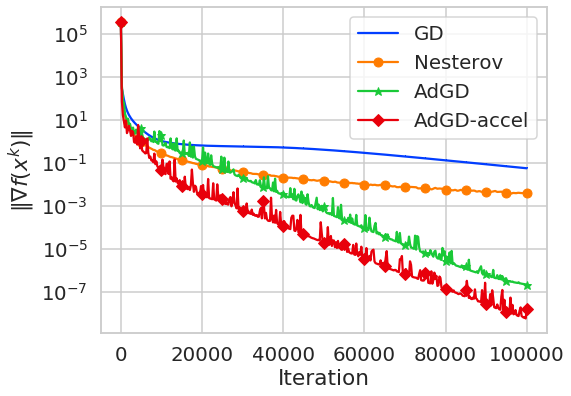

In [14]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)


answers = [ans1, ans2, ans3, ans4]
values = [ans[0] for ans in answers]
labels = ["GD", "Nesterov", "AdGD", "AdGD-accel"]
markers = [',', 'o', '*',  'D']

n_plot = 400
plt.figure(figsize=(8,6))
for i, val in enumerate(values):
    skip = len(val) // n_plot
    plt.plot(
        np.arange(0, len(val), skip), 
        val[::skip], label=labels[i],
        marker=markers[i], markevery=20)
    
plt.yscale('log')
plt.xlabel(u'Iteration')
plt.ylabel(r'$\Vert \nabla f(x^k)\Vert$')
plt.legend()
#plt.savefig('saved_data/factorization={}.pdf'.format(r), bbox_inches='tight', dpi=300)


Save all data points

In [ ]:
np.save('saved_data/factorization-{}.npy'.format(r), np.vstack([ans[0] for ans in answers]))  
#values = np.load('saved_data/factorization-{}.npy'.format(r))